The code is from https://github.com/HarshSulakhe/3DMNIST-PyTorch

# Import Packages

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
from utils.plot3D import *
from utils.utils import *

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


# Load the vectors 

In [4]:
with h5py.File('/home/asabuncuoglu13/dataset/mnist3d/full_dataset_vectors.h5', "r") as hf:    
    X_train = hf["X_train"][:]
    targets_train = hf["y_train"][:]
    X_test = hf["X_test"][:] 
    targets_test = hf["y_test"][:]
    
X_train = rgb_data_transform(X_train)
X_test = rgb_data_transform(X_test)

# Create Datasets and Dataloaders

In [5]:
train_x = torch.from_numpy(X_train).float()
train_y = torch.from_numpy(targets_train).long()
test_x = torch.from_numpy(X_test).float()
test_y = torch.from_numpy(targets_test).long()

batch_size = 100

train_ds = torch.utils.data.TensorDataset(train_x,train_y)
test_ds = torch.utils.data.TensorDataset(test_x,test_y)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size = batch_size, shuffle = False)

# CNN and Linear Models

In [22]:
import torch.nn.init as init
import math

class AttentionConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, bias=False):
        super(AttentionConv3d, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.rel_h = nn.Parameter(torch.randn(out_channels // 2, 1, 1, kernel_size, 1), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn(out_channels // 2, 1, 1, 1, kernel_size), requires_grad=True)

        self.key_conv = nn.Conv3d(in_channels, out_channels, kernel_size=3, bias=bias)
        self.query_conv = nn.Conv3d(in_channels, out_channels, kernel_size=3, bias=bias)
        self.value_conv = nn.Conv3d(in_channels, out_channels, kernel_size=3, bias=bias)

        self.reset_parameters()

    def forward(self, x):
        batch, channels, height, width, d = x.size()
        #print("x size:", x.size())

        pad = nn.ReplicationPad3d(self.padding)
        padded_x = pad(x)
        #print("padded x size:", padded_x.size())
        
        q_out = self.query_conv(x)
        #print("q_out:", q_out.shape)
        
        k_out = self.key_conv(x)
        #print("k_out:", k_out.shape)
        
        v_out = self.value_conv(x)
        #print("v_out:", v_out.shape)
        
        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height - self.padding, width - self.padding, d - self.padding, -1)
        v_out = v_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height - self.padding, width - self.padding, d - self.padding, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height - self.padding, width - self.padding, d - self.padding, 1)
        
        out = torch.matmul(q_out, (k_out).transpose(-1, -2))
        out = F.softmax(out, dim=-1)
        out = torch.matmul(out, v_out).view(batch, -1, height- self.padding, width - self.padding, d - self.padding)
        return out

    def reset_parameters(self):
        init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.value_conv.weight, mode='fan_out', nonlinearity='relu')
        init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')

        init.normal_(self.rel_h, 0, 1)
        init.normal_(self.rel_w, 0, 1)

In [23]:
class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel,self).__init__()
        self.conv1 = nn.Sequential(
            AttentionConv3d(3, 8, kernel_size=5, padding=2, groups=2),
            nn.BatchNorm3d(8),
            nn.ReLU(),
        )        
        #self.conv1 = nn.Conv3d(3,8,3)
        self.conv2 = nn.Conv3d(8,32,3)
        self.conv3 = nn.Conv3d(32,32,3)
        # self.conv4 = nn.Conv3d(64,128,3)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool3d(4)
        # self.pool2 = nn.MaxPool3d(2)
        # self.linear1 = nn.Linear(128*8,128)
        self.linear2 = nn.Linear(32,10)
        self.batchnorm = nn.BatchNorm3d(32)
        self.dropout = nn.Dropout(0.5)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        # x = self.conv4(x)
        # x = self.pool1(x)
        x = self.batchnorm(x)
        x = x.view(x.size()[0],-1)
        # x = self.linear1(x)
        # x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# Define Hyperparameters

In [24]:
num_epochs = 40

model = CNNModel()
model = model.cuda()

error = nn.CrossEntropyLoss()

learning_rate = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the Model

I set the #of epochs to ~40, as the model tends to overfit after this step.

In [25]:
train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []
for epoch in range(num_epochs):
    model.train()
    running_acc = 0
    train_loss = 0
    for i, (images, labels) in enumerate(train_loader):     
        train = Variable(images.permute(0,4,1,2,3)).cuda()
        labels = Variable(labels).cuda()
        optimizer.zero_grad()
        outputs = model(train)
        loss = error(outputs, labels)
        train_loss+=loss.data
        train_accuracy = accuracy_score(torch.argmax(outputs,axis = 1).cpu().numpy(),labels.cpu().numpy())
        running_acc+=train_accuracy*len(images)
        loss.backward()
        optimizer.step()
#         scheduler.step()
    running_acc/=len(train_ds)
    train_loss/=5
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            test = Variable(images.permute(0,4,1,2,3)).cuda()
            outputs = model(test).detach()
            test_loss = error(outputs,labels.cuda())
            test_accuracy = accuracy_score(torch.argmax(outputs,axis = 1).cpu().numpy(),labels.cpu().numpy())
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss.data)
    test_accuracy_list.append(test_accuracy)
    train_accuracy_list.append(train_accuracy)
    

    print('Epoch: {}  Train Loss:{:.2f}, Test Loss:{:.2f}, Train Accuracy:{:.2f}, Test Accuracy:{:.2f}'.format(epoch, train_loss,test_loss,train_accuracy,test_accuracy))

Epoch: 0  Train Loss:46.04, Test Loss:1.85, Train Accuracy:0.33, Test Accuracy:0.35
Epoch: 1  Train Loss:40.47, Test Loss:1.69, Train Accuracy:0.34, Test Accuracy:0.46
Epoch: 2  Train Loss:36.95, Test Loss:1.60, Train Accuracy:0.42, Test Accuracy:0.51
Epoch: 3  Train Loss:34.51, Test Loss:1.56, Train Accuracy:0.50, Test Accuracy:0.52
Epoch: 4  Train Loss:33.03, Test Loss:1.51, Train Accuracy:0.55, Test Accuracy:0.53
Epoch: 5  Train Loss:31.92, Test Loss:1.48, Train Accuracy:0.50, Test Accuracy:0.52
Epoch: 6  Train Loss:31.08, Test Loss:1.46, Train Accuracy:0.50, Test Accuracy:0.52
Epoch: 7  Train Loss:30.26, Test Loss:1.44, Train Accuracy:0.56, Test Accuracy:0.54
Epoch: 8  Train Loss:29.71, Test Loss:1.42, Train Accuracy:0.52, Test Accuracy:0.56
Epoch: 9  Train Loss:29.16, Test Loss:1.40, Train Accuracy:0.52, Test Accuracy:0.58
Epoch: 10  Train Loss:28.64, Test Loss:1.39, Train Accuracy:0.53, Test Accuracy:0.56
Epoch: 11  Train Loss:28.41, Test Loss:1.38, Train Accuracy:0.58, Test Accu

## Test the Model

In [26]:
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        test = Variable(images.permute(0,4,1,2,3)).cuda()
        outputs = model(test).detach()
        test_loss = error(outputs,labels.cuda())
        test_accuracy = accuracy_score(torch.argmax(outputs,axis = 1).cpu().numpy(),labels.cpu().numpy())
print(test_accuracy)
torch.save(model.state_dict,'./CNN_5e-5.pth')

0.64


# Generate Plots

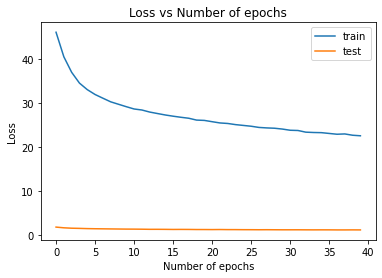

In [27]:
plt.plot(train_loss_list,label = 'train')
plt.plot(test_loss_list,label = 'test')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")
plt.show()

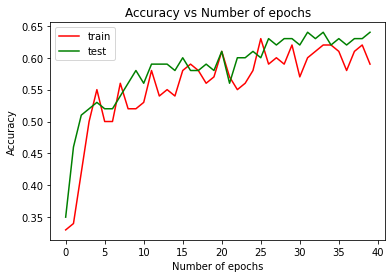

In [28]:
plt.plot(train_accuracy_list,color = "red",label = 'train')
plt.plot(test_accuracy_list,color = "green",label = 'test')
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of epochs")
plt.show()

In [29]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/3dmnist')
test = Variable(images.permute(0,4,1,2,3)).cuda()
writer.add_graph(model,test)
# writer.close()